# Imports

In [1]:
from time import time
import datetime
import pandas as pd 
import numpy as np
import tensorflow as tf
import keras
from tqdm import tqdm_notebook as tqdm
#!pip install -q git+https://github.com/oanda/oandapy.git
import oandapy as opy
from datetime import datetime as dt
from datetime import timedelta

#!pip install statsmodels
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import numpy as np
from tpot import TPOTClassifier, TPOTRegressor
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import math
from sklearn.metrics import roc_curve
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
import keras.layers as kl
from keras.callbacks import TensorBoard, EarlyStopping
%matplotlib notebook

/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Data

In [ ]:
oanda = opy.API(environment='live')

In [ ]:
# Input for downloading data using Oanda API
d1 = '2008-01-01'
d2 = str(dt.now())[:10]
instrument = 'USD_JPY'

In [ ]:
# Download data in chucks
dates = pd.date_range(start=d1, end=d2, freq='D')
df = pd.DataFrame()

print('Se van a descargar {} días'.format(len(dates)))
print('Descargando:')
pbar = tqdm(total=len(dates) - 1)
for i in range(0, len(dates) - 1):
    d1 = str(dates[i]).replace(' ', 'T')
    d2 = str(dates[i+1]).replace(' ', 'T')
     
    try:
        data = oanda.get_history(instrument=instrument, start=d1, end=d2, granularity='M5')
        df = df.append(pd.DataFrame(data['candles']))
        pbar.update(1)
    except:
        pass
pbar.close()
date = pd.DatetimeIndex(df['time'], tz='UTC')
df['date'] = date

In [ ]:
DF = df.copy()

# --------------------------------------------------------------------------

In [ ]:
df = DF.copy()

In [2]:
df = pd.read_csv('USD_JPY_M5.csv', index_col=0)

In [3]:
df.head()

,closeAsk,closeBid,complete,highAsk,highBid,lowAsk,lowBid,openAsk,openBid,time,volume,date
0,111.786,111.586,True,111.786,111.586,111.786,111.586,111.786,111.586,2008-01-01T18:00:00.000000Z,1,2008-01-01 18:00:00+00:00
1,111.740,111.540,True,111.740,111.540,111.740,111.540,111.740,111.540,2008-01-01T18:05:00.000000Z,1,2008-01-01 18:05:00+00:00
2,111.723,111.473,True,111.765,111.515,111.723,111.473,111.765,111.515,2008-01-01T18:10:00.000000Z,3,2008-01-01 18:10:00+00:00
3,111.539,111.439,True,111.604,111.439,111.524,111.344,111.599,111.349,2008-01-01T18:35:00.000000Z,15,2008-01-01 18:35:00+00:00
4,111.555,111.455,True,111.559,111.459,111.520,111.420,111.539,111.439,2008-01-01T18:40:00.000000Z,20,2008-01-01 18:40:00+00:00


In [4]:
df = df.reset_index(drop=True)

In [5]:
df = df[150:]

In [6]:
df = df.drop(['complete', 'time'], axis=1)

In [7]:
for i in [j for j in df.columns if j not in ['date', 'volume']]:
    df['diff ' + i] = df[i] - df[i].shift(1)

In [8]:
drp = ['closeAsk',
       'closeBid',
       'highAsk',
       'highBid',
       'lowAsk',
       'lowBid',
       'openAsk',
       'openBid']
df = df.drop(drp, axis=1)

In [9]:
min_window = 5
step = int(60/min_window)

open_bid = ['diff openBid' + str(min_window*(i+1)) for i in range(step)]
open_ask = ['diff openAsk' + str(min_window*(i+1)) for i in range(step)]
close_bid = ['diff closeBid' + str(min_window*(i+1)) for i in range(step)]
close_ask = ['diff closeAsk' + str(min_window*(i+1)) for i in range(step)]
low_bid = ['diff lowBid' + str(min_window*(i+1)) for i in range(step)]
low_ask = ['diff lowAsk' + str(min_window*(i+1)) for i in range(step)]
high_bid = ['diff highBid' + str(min_window*(i+1)) for i in range(step)]
high_ask = ['diff highAsk' + str(min_window*(i+1)) for i in range(step)]
volume = ['volume' + str(min_window*(i+1)) for i in range(step)]

In [10]:
shifts = list(range(1,step+1))

In [11]:
for v, ob, oa, cb, ca, lb, la, hb, ha, s in zip(volume,
                                             open_bid, 
                                             open_ask, 
                                             close_bid, 
                                             close_ask, 
                                             low_bid, 
                                             low_ask, 
                                             high_bid, 
                                             high_ask, 
                                             shifts):
    df[v] = df['volume'].shift(s)
    df[ob] = df['diff openBid'].shift(s)
    df[oa] = df['diff openAsk'].shift(s)
    df[cb] = df['diff closeBid'].shift(s)
    df[ca] = df['diff closeAsk'].shift(s)
    df[lb] = df['diff lowBid'].shift(s)
    df[la] = df['diff lowAsk'].shift(s)
    df[hb] = df['diff highBid'].shift(s)
    df[ha] = df['diff highAsk'].shift(s)

In [12]:
df = df[13:]

In [13]:
df['date'] = df['date'].astype(str)

In [14]:
df['d2'] = df['date'].str[14:]

In [15]:
df = df[df['d2'] == '00:00+00:00']

In [16]:
fake_drop = volume + ['volume', 'date', 'd2']
df['H'] = df.drop(fake_drop, 1).max(axis=1)
df['L'] = df.drop(fake_drop, 1).min(axis=1)
df['vol'] = df[volume].sum(axis=1)

In [17]:
drop = ['d2']
df = df.drop(drop, axis=1)

# Twitter

In [18]:
import psycopg2
import logging
import os

def db_conn():
    """
    Método que hace la conexión a la base de datos
    Args:
        conn_creds(dict): diccionario donde vienen las credenciales de
        la conexión a la base de datos
                         host(str): host que hospeda a la base de datos
                         port(str): puerto donde está disponible la base de datos
                         user(str): usuario con el que se hará la conexión
                         password(str): contraseña del usuario en la BD
                         database(str): nombre de la base de datos
    Returns:
        conn: objeto que contiene la sesión de una conexión a la BD
    """
    try:
        conn = psycopg2.connect(
            host=os.environ['ID_HOST'],
            port=os.environ['ID_PORT'],
            user=os.environ['ID_USER'],
            password=os.environ['ID_PASSWORD'],
            database=os.environ['ID_DB'],
        )
    except Exception as error:
        logging.error(error)

    return conn

def download(conn, query):
    """
    Descarga datos de la base de datos según la consulta insertada
    Args:
        conn (connection): objeto que contiene la sesión de una
                           conexión a la base de datos
        query (str): String donde se define el query a ejecutarse
    Returns:
        df (DataFrame): Tabla con los datos que elegimos
    """
    try:
        df = pd.read_sql(query, conn)
        conn.commit()
    finally:
        conn.close()


    return df

In [19]:
conn = db_conn()
query = '''SELECT date_trunc('hour',cast(date as timestamp)), avg(polarity) polarity, avg(subjectivity) subjectivity
           FROM tweets GROUP BY date_trunc('hour',cast(date as timestamp))'''
tw = download(conn, query)

In [20]:
tw['date_trunc'] = tw['date_trunc'] + timedelta(hours=5)

# JOIN

In [21]:
df['date'] = df['date'].str[:13]

In [22]:
tw['date_trunc'] = tw['date_trunc'].astype(str)
tw['date_trunc'] = tw['date_trunc'].str[:13]

In [23]:
df = pd.merge(df,tw,left_on='date',right_on='date_trunc',how='left')

In [24]:
df.head()

,volume,date,diff closeAsk,diff closeBid,diff highAsk,diff highBid,diff lowAsk,diff lowBid,diff openAsk,diff openBid,volume5,diff openBid5,diff openAsk5,diff closeBid5,diff closeAsk5,diff lowBid5,diff lowAsk5,diff highBid5,diff highAsk5,volume10,diff openBid10,diff openAsk10,diff closeBid10,diff closeAsk10,diff lowBid10,diff lowAsk10,diff highBid10,diff highAsk10,volume15,diff openBid15,diff openAsk15,diff closeBid15,diff closeAsk15,diff lowBid15,diff lowAsk15,diff highBid15,diff highAsk15,volume20,diff openBid20,diff openAsk20,diff closeBid20,diff closeAsk20,diff lowBid20,diff lowAsk20,diff highBid20,diff highAsk20,volume25,diff openBid25,diff openAsk25,diff closeBid25,diff closeAsk25,diff lowBid25,diff lowAsk25,diff highBid25,diff highAsk25,volume30,diff openBid30,diff openAsk30,diff closeBid30,diff closeAsk30,diff lowBid30,diff lowAsk30,diff highBid30,diff highAsk30,volume35,diff openBid35,diff openAsk35,diff closeBid35,diff closeAsk35,diff lowBid35,diff lowAsk35,diff highBid35,diff highAsk35,volume40,diff openBid40,diff openAsk40,diff closeBid40,diff closeAsk40,diff lowBid40,diff lowAsk40,diff highBid40,diff highAsk40,volume45,diff openBid45,diff openAsk45,diff closeBid45,diff closeAsk45,diff lowBid45,diff lowAsk45,diff highBid45,diff highAsk45,volume50,diff openBid50,diff openAsk50,diff closeBid50,diff closeAsk50,diff lowBid50,diff lowAsk50,diff highBid50,diff highAsk50,volume55,diff openBid55,diff openAsk55,diff closeBid55,diff closeAsk55,diff lowBid55,diff lowAsk55,diff highBid55,diff highAsk55,volume60,diff openBid60,diff openAsk60,diff closeBid60,diff closeAsk60,diff lowBid60,diff lowAsk60,diff highBid60,diff highAsk60,H,L,vol,date_trunc,polarity,subjectivity
0,110,2008-01-02 08,0.090,0.090,0.115,0.115,0.085,0.085,0.080,0.080,88.0,0.025,0.025,0.077,0.077,0.028,0.028,0.070,0.070,51.0,0.060,0.060,0.018,0.018,0.052,0.052,0.025,0.025,71.0,-0.040,-0.040,0.060,0.060,-0.010,-0.010,0.015,0.015,49.0,0.010,0.010,-0.035,-0.035,-0.025,-0.025,-0.003,-0.003,60.0,-0.010,-0.010,0.005,0.005,0.005,0.005,-0.027,-0.027,52.0,0.065,0.065,-0.005,-0.005,0.050,0.050,0.040,0.040,52.0,-0.105,-0.105,0.060,0.060,-0.001,-0.001,-0.045,-0.045,63.0,0.056,0.056,-0.100,-0.100,-0.034,-0.034,0.005,0.005,69.0,0.052,0.052,0.050,0.050,0.045,0.045,0.050,0.050,59.0,0.056,0.056,0.053,0.053,0.055,0.055,0.043,0.043,59.0,0.021,0.021,0.057,0.057,0.025,0.025,0.067,0.067,63.0,-0.005,-0.005,0.025,0.025,-0.006,-0.006,-0.010,-0.010,0.115,-0.105,736.0,2008-01-02 08,0.000000,0.000000
1,108,2008-01-02 09,-0.025,-0.025,-0.114,-0.114,-0.042,-0.042,-0.092,-0.092,80.0,0.072,0.072,-0.096,-0.096,-0.015,-0.015,0.012,0.012,118.0,0.065,0.065,0.086,0.086,0.068,0.068,0.090,0.090,53.0,-0.015,-0.015,0.055,0.055,-0.013,-0.013,0.035,0.035,76.0,-0.055,-0.055,-0.005,-0.005,-0.015,-0.015,-0.080,-0.080,130.0,-0.120,-0.120,-0.065,-0.065,-0.050,-0.050,-0.105,-0.105,210.0,-0.040,-0.040,-0.110,-0.110,-0.125,-0.125,-0.020,-0.020,75.0,-0.041,-0.041,-0.050,-0.050,-0.040,-0.040,-0.045,-0.045,68.0,0.017,0.017,-0.037,-0.037,-0.020,-0.020,-0.030,-0.030,93.0,-0.051,-0.051,0.020,0.020,0.020,0.020,0.000,0.000,78.0,0.027,0.023,-0.048,-0.048,-0.028,-0.032,-0.090,-0.090,176.0,0.090,0.090,0.027,0.023,0.070,0.070,0.097,0.093,110.0,0.080,0.080,0.090,0.090,0.085,0.085,0.115,0.115,0.115,-0.125,1267.0,2008-01-02 09,-0.040000,0.160000
2,53,2008-01-02 10,-0.005,-0.005,-0.023,-0.023,-0.005,-0.005,-0.030,-0.030,81.0,0.030,0.030,-0.011,-0.011,0.000,0.000,0.021,0.021,14.0,0.000,0.000,0.021,0.021,0.010,0.010,-0.013,-0.013,45.0,0.015,0.015,-0.005,-0.005,0.050,0.050,0.032,0.032,67.0,-0.045,-0.045,0.025,0.025,-0.030,-0.030,-0.030,-0.030,80.0,-0.005,-0.005,-0.050,-0.050,0.015,0.015,-0.008,-0.008,161.0,-0.060,-0.060,-0.005,-0.005,-0.065,-0.065,-0.062,-0.062,61.0,0.015,0.015,-0.070,-0.070,-0.060,-0.060,-0.094,-0.094,101.0,0.137,0.137,0.025,0.025,0.142,0.142,0.049,0.049,126.0,0.015,0.015,0.137,0.137,0.025,0.025,0.177,0.177,84.0,-0.022,-0.022,0.000,0.000,-0.015,-0.015,-0.012,-0.012,101.0,-0.030,-0.030,-0.022,-0.022,0.000,0.000,

In [25]:
df = df.drop(['date', 'date_trunc'], axis=1)

In [26]:
df.head()

,volume,diff closeAsk,diff closeBid,diff highAsk,diff highBid,diff lowAsk,diff lowBid,diff openAsk,diff openBid,volume5,diff openBid5,diff openAsk5,diff closeBid5,diff closeAsk5,diff lowBid5,diff lowAsk5,diff highBid5,diff highAsk5,volume10,diff openBid10,diff openAsk10,diff closeBid10,diff closeAsk10,diff lowBid10,diff lowAsk10,diff highBid10,diff highAsk10,volume15,diff openBid15,diff openAsk15,diff closeBid15,diff closeAsk15,diff lowBid15,diff lowAsk15,diff highBid15,diff highAsk15,volume20,diff openBid20,diff openAsk20,diff closeBid20,diff closeAsk20,diff lowBid20,diff lowAsk20,diff highBid20,diff highAsk20,volume25,diff openBid25,diff openAsk25,diff closeBid25,diff closeAsk25,diff lowBid25,diff lowAsk25,diff highBid25,diff highAsk25,volume30,diff openBid30,diff openAsk30,diff closeBid30,diff closeAsk30,diff lowBid30,diff lowAsk30,diff highBid30,diff highAsk30,volume35,diff openBid35,diff openAsk35,diff closeBid35,diff closeAsk35,diff lowBid35,diff lowAsk35,diff highBid35,diff highAsk35,volume40,diff openBid40,diff openAsk40,diff closeBid40,diff closeAsk40,diff lowBid40,diff lowAsk40,diff highBid40,diff highAsk40,volume45,diff openBid45,diff openAsk45,diff closeBid45,diff closeAsk45,diff lowBid45,diff lowAsk45,diff highBid45,diff highAsk45,volume50,diff openBid50,diff openAsk50,diff closeBid50,diff closeAsk50,diff lowBid50,diff lowAsk50,diff highBid50,diff highAsk50,volume55,diff openBid55,diff openAsk55,diff closeBid55,diff closeAsk55,diff lowBid55,diff lowAsk55,diff highBid55,diff highAsk55,volume60,diff openBid60,diff openAsk60,diff closeBid60,diff closeAsk60,diff lowBid60,diff lowAsk60,diff highBid60,diff highAsk60,H,L,vol,polarity,subjectivity
0,110,0.090,0.090,0.115,0.115,0.085,0.085,0.080,0.080,88.0,0.025,0.025,0.077,0.077,0.028,0.028,0.070,0.070,51.0,0.060,0.060,0.018,0.018,0.052,0.052,0.025,0.025,71.0,-0.040,-0.040,0.060,0.060,-0.010,-0.010,0.015,0.015,49.0,0.010,0.010,-0.035,-0.035,-0.025,-0.025,-0.003,-0.003,60.0,-0.010,-0.010,0.005,0.005,0.005,0.005,-0.027,-0.027,52.0,0.065,0.065,-0.005,-0.005,0.050,0.050,0.040,0.040,52.0,-0.105,-0.105,0.060,0.060,-0.001,-0.001,-0.045,-0.045,63.0,0.056,0.056,-0.100,-0.100,-0.034,-0.034,0.005,0.005,69.0,0.052,0.052,0.050,0.050,0.045,0.045,0.050,0.050,59.0,0.056,0.056,0.053,0.053,0.055,0.055,0.043,0.043,59.0,0.021,0.021,0.057,0.057,0.025,0.025,0.067,0.067,63.0,-0.005,-0.005,0.025,0.025,-0.006,-0.006,-0.010,-0.010,0.115,-0.105,736.0,0.000000,0.000000
1,108,-0.025,-0.025,-0.114,-0.114,-0.042,-0.042,-0.092,-0.092,80.0,0.072,0.072,-0.096,-0.096,-0.015,-0.015,0.012,0.012,118.0,0.065,0.065,0.086,0.086,0.068,0.068,0.090,0.090,53.0,-0.015,-0.015,0.055,0.055,-0.013,-0.013,0.035,0.035,76.0,-0.055,-0.055,-0.005,-0.005,-0.015,-0.015,-0.080,-0.080,130.0,-0.120,-0.120,-0.065,-0.065,-0.050,-0.050,-0.105,-0.105,210.0,-0.040,-0.040,-0.110,-0.110,-0.125,-0.125,-0.020,-0.020,75.0,-0.041,-0.041,-0.050,-0.050,-0.040,-0.040,-0.045,-0.045,68.0,0.017,0.017,-0.037,-0.037,-0.020,-0.020,-0.030,-0.030,93.0,-0.051,-0.051,0.020,0.020,0.020,0.020,0.000,0.000,78.0,0.027,0.023,-0.048,-0.048,-0.028,-0.032,-0.090,-0.090,176.0,0.090,0.090,0.027,0.023,0.070,0.070,0.097,0.093,110.0,0.080,0.080,0.090,0.090,0.085,0.085,0.115,0.115,0.115,-0.125,1267.0,-0.040000,0.160000
2,53,-0.005,-0.005,-0.023,-0.023,-0.005,-0.005,-0.030,-0.030,81.0,0.030,0.030,-0.011,-0.011,0.000,0.000,0.021,0.021,14.0,0.000,0.000,0.021,0.021,0.010,0.010,-0.013,-0.013,45.0,0.015,0.015,-0.005,-0.005,0.050,0.050,0.032,0.032,67.0,-0.045,-0.045,0.025,0.025,-0.030,-0.030,-0.030,-0.030,80.0,-0.005,-0.005,-0.050,-0.050,0.015,0.015,-0.008,-0.008,161.0,-0.060,-0.060,-0.005,-0.005,-0.065,-0.065,-0.062,-0.062,61.0,0.015,0.015,-0.070,-0.070,-0.060,-0.060,-0.094,-0.094,101.0,0.137,0.137,0.025,0.025,0.142,0.142,0.049,0.049,126.0,0.015,0.015,0.137,0.137,0.025,0.025,0.177,0.177,84.0,-0.022,-0.022,0.000,0.000,-0.015,-0.015,-0.012,-0.012,101.0,-0.030,-0.030,-0.022,-0.022,0.000,0.000,-0.003,-0.003,108.0,-0.092,-0.092,-0.025,-0.025,-0.042,-0.042,-0.114,-0.114,0.177,-0.1

In [27]:
df = df.fillna(method='ffill')

In [28]:
def train_test(Data, response, time_series=False):
    """
    Regresa train y test sets con el 75% de los datos
    para entrenar y el 25% para probar el modelo
    
    Args:
        Data (DataFrame): Datos listos para el modelo
        response (str): Variable respuesta
        time_series (boolean): Si es serie de tiempo o no
    Returns:
        X_train (Array): conjunto de datos de entrenamiento (indep)
        X_test (Array): conjunto de datos de prueba (indep)
        y_train (Array): conjunto de datos de entrenamiento (dep)
        y_test (Array): conjunto de datos de prueba (dep)
        
    """
    
    Data1 = Data.copy()
    X = Data1.drop(response, 1)
    y = Data1[response]
    print('X Variables: ')
    print(X.columns)
    print('\nResponse:')
    print(response)
    
    if time_series:
        tscv = TimeSeriesSplit(n_splits=2)
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.values[train_index], X.values[test_index]
            y_train, y_test = y.values[train_index], y.values[test_index]
    
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 0)
        X_train = X_train.values
        X_test = X_test.values
        y_train = y_train.values
        y_test = y_test.values
    
    return X_train, X_test, y_train, y_test

def tpotclass(X_train, y_train):
    """
    Usando TPOT (Tree-Based Pipeline Optimization Tool), librería de AutoML,
    genera el "mejor" modelo de clasificación automáticamente
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        tpotmod (modelo): Modelo de clasificación generado con TPOT
    """
    pipeline_optimizer = TPOTClassifier(generations=5,
                                        population_size=50,
                                        cv=5,
                                        random_state=42,
                                        verbosity=2,
                                        n_jobs=4)
    tpotmod = pipeline_optimizer.fit(X_train, y_train)

    return tpotmod

def tpotreg(X_train, y_train):
    """
    Usando TPOT (Tree-Based Pipeline Optimization Tool), librería de AutoML,
    genera el "mejor" modelo de regresión automáticamente
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        tpotmod (modelo): Modelo de regresión generado con TPOT
    """

    pipeline_optimizer = TPOTRegressor(generations=5,
                                       population_size=50,
                                       cv=5,
                                       random_state=42,
                                       verbosity=2,
                                       n_jobs=4)
    tpotmod = pipeline_optimizer.fit(X_train, y_train)

    return tpotmod

def logreg(X_train, y_train):
    """
    Calcula modelo de Regresión Logística
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        logreg (modelo): Regresión Logística
    """
    try:
        # Si la matriz es singular va a dar error
        log = sm.Logit(y_train, X_train)
        logreg_model = log.fit()
    except Exception as e:
        # Intentamos con la matriz hessiana
        print(e)
        log = sm.Logit(y_train, X_train)
        logreg_model = log.fit(method='bfgs')

    return logreg_model

def linreg(X_train, y_train):
    """
    Calcula modelo de Regresión Lineal
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        linreg_model (modelo): Regresión Lineal
    """
    linreg = sm.OLS(y_train, X_train)
    linreg_model = linreg.fit()

    return linreg_model

def simple_model(X_train, y_train, tpot=False):
    """
    Obtiene variable objetivo, decide si es de clasificación o regresión
    y regresa un modelo simple
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
        tpot (boolean): si queremos generar modelo con tpot
    Returns:
        model (modelo): Regresión Logística o Lineal dependiendo de la variable
                         objetivo
        tpotmod (modelo): Modelo de Regresión o Clasificación generado con TPOT
    """
    tpotm = None
    # Revisamos si es modelo de clasificación binaria
    if len(set(np.unique(y_train))) == 2:
        model = logreg(X_train, y_train)
        if tpot:
            toptm = tpotclass(X_train, y_train)
    elif len(set(np.unique(y_train))) > 2 and len(set(np.unique(y_train))) < 10:
        multilog = sm.MNLogit(y_train, X_train)
        model = multilog.fit()
        if tpot:
            tpotm = tpotclass(X_train, y_train)
    else:
        model = linreg(X_train, y_train)
        if tpot:
            tpotm = tpotreg(X_train, y_train)

    return model, tpotm


  
def rnn_reg(X_train, y_train, bs=1024, epcs=100):
  
    model = Sequential()

    model.add(LSTM(1000, activation='tanh', return_sequences=True, input_shape=(1, X_train.shape[1]), recurrent_dropout=0.5))
    model.add(LSTM(100, activation='tanh', return_sequences=True, recurrent_activation = 'hard_sigmoid', recurrent_dropout=0.4))          
    model.add(LSTM(10, activation='tanh', recurrent_activation = 'hard_sigmoid', recurrent_dropout=0.2))
    model.add(Dense(activation="linear", units=1))

    model.compile(loss ="mean_squared_error" , optimizer = "adam", metrics = ["mean_squared_error", "accuracy"])
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    
    tensorboard = TensorBoard(log_dir="logs/{}(batches {})".format(datetime.datetime.now(),bs), 
                              histogram_freq=0, 
                              batch_size=bs, 
                              write_graph=True, 
                              write_grads=False, 
                              write_images=False, 
                              update_freq='epoch')
    
    early_stopping = EarlyStopping(monitor='val_loss',
                                   min_delta=0,
                                   patience=5,
                                   verbose=1,
                                   mode='auto',
                                   restore_best_weights=True)
    
    model.fit(X_train, y_train, verbose=1, batch_size=bs, epochs=epcs, validation_split=0.25, callbacks=[tensorboard, early_stopping])
   
    return model

def rnn_class(X_train, y_train, bs=1024, epcs=5):
    
    model = Sequential()
    
    model.add(LSTM(1000, activation='tanh', return_sequences=True, input_shape=(1, X_train.shape[1]), recurrent_dropout=0.5))
    model.add(LSTM(100, activation='tanh', return_sequences=True, recurrent_activation = 'hard_sigmoid', recurrent_dropout=0.4))          
    model.add(LSTM(10, activation='tanh', recurrent_activation = 'hard_sigmoid', recurrent_dropout=0.2))
    
    model.add(Dense(activation="sigmoid", units=1))

    model.compile(loss ="binary_crossentropy" , optimizer = "adam", metrics = ["accuracy"])
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    
    tensorboard = TensorBoard(log_dir="logs/{}(batches {})".format(datetime.datetime.now(),bs), histogram_freq=0, batch_size=bs, write_graph=True, write_grads=False, write_images=False, update_freq='epoch')
    model.fit(X_train, y_train, shuffle = False, verbose=1, batch_size=bs, epochs=epcs, validation_split=0.05, callbacks=[tensorboard])
   
    return model

def model_precision(y_test, predictions, lim):
    """
    Args:
        y_test (array): Instancias de la variable dependiente
        predictions (array): Predicciones
        lim (float): Entre 0 y 1 que marca el límite de clasificación (arriba de lim se considera cierre)
    
    Returns:
        Accuracy (float): (tp+tn)/(tp+tn+fp+fn)
        Precision (float): tp/(tp+fp)
        Recall (float): tp/(tp+fn)
        F1_score (float): 2/(1/Precision+1/Recall) Media armónica entre Precision y Recall
        MCC (float): Matthiews Correlation Coefficient (tp*tn-fp*fn)/(math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
    
    """
          
    y_test.shape = [y_test.shape[0],1]
    predictions.shape = [predictions.shape[0],1]
    
    test = np.concatenate((y_test, predictions),axis=1)

    tp = ((test[:,0] == 1) & (test[:,1] >= lim)).sum()
    fp = ((test[:,0] == 0) & (test[:,1] >= lim)).sum()
    tn = ((test[:,0] == 0) & (test[:,1] < lim)).sum()
    fn = ((test[:,0] == 1) & (test[:,1] < lim)).sum()
    
    Accuracy = (tp+tn)/(tp+tn+fp+fn)
    Precision = tp/(tp+fp)
    Recall = tp/(tp+fn)
    F1_score = 2/(1/Precision+1/Recall)
    MCC = (tp*tn-fp*fn)/(math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
    

    res = pd.DataFrame(0, index=['Accuracy', 'Precision',
                                     'Recall', 'F1 Score',
                                     'MCC'], columns=['Score'])

    res.loc['Accuracy'] = 100*Accuracy
    res.loc['Precision'] = 100*Precision
    res.loc['Recall'] = 100*Recall
    res.loc['F1 Score'] = 100*F1_score
    res.loc['MCC'] = 100*MCC
    display(res)
    
    return Accuracy, Precision, Recall, F1_score, MCC

def bucket_scores(y_test, predictions):
    """
    Precision por cubeta de 10 en 10
    
    Args:
        y_test (array): Instancias de la variable dependiente
        predictions (array): Predicciones
    
    Returns:
        res (DataFrame): Positive rate por scores de 1 a 100 en cubetas de 10
    
    """
    scoresindex = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100']
    scorescolumns = ['Total','Positives']
    res = pd.DataFrame(0, index=scoresindex, columns=scorescolumns)
    
    y_test.shape = [y_test.shape[0],1]
    predictions.shape = [predictions.shape[0],1]
    
    test = np.concatenate((y_test,predictions),axis=1)
    
    low = 0
    up = 0.1
    for i in scoresindex:
        res.loc[i]['Total'] = ((test[:,1] >= low) & (test[:,1] < up)).sum()
        res.loc[i]['Positives'] = ((test[:,1] >= low) & (test[:,1] < up) & (test[:,0] == 1)).sum()
        low += 0.1
        up += 0.1
    res['Positive Rate'] = res['Positives']/res['Total']*100  
    
    return res

# Price

## Future Close (price)

X Variables: 
Index(['volume', 'diff closeAsk', 'diff closeBid', 'diff highAsk',
       'diff highBid', 'diff lowAsk', 'diff lowBid', 'diff openAsk',
       'diff openBid', 'volume5',
       ...
       'diff closeAsk60', 'diff lowBid60', 'diff lowAsk60', 'diff highBid60',
       'diff highAsk60', 'H', 'L', 'vol', 'polarity', 'subjectivity'],
      dtype='object', length=122)

Response:
Future CloseBid


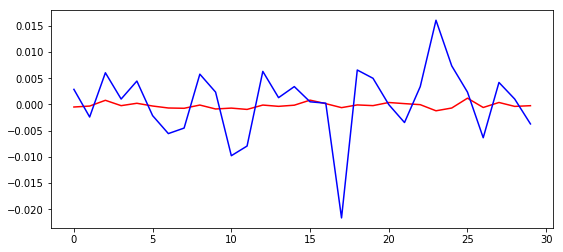

Train on 33870 samples, validate on 11290 samples
Epoch 1/100
33870/33870 [==============================] - 25s 750us/step - loss: 1.8232e-04 - mean_squared_error: 1.8232e-04 - acc: 0.0000e+00 - val_loss: 1.5259e-04 - val_mean_squared_error: 1.5259e-04 - val_acc: 0.0000e+00
Epoch 2/100
33870/33870 [==============================] - 24s 703us/step - loss: 1.8146e-04 - mean_squared_error: 1.8146e-04 - acc: 0.0000e+00 - val_loss: 1.5262e-04 - val_mean_squared_error: 1.5262e-04 - val_acc: 0.0000e+00
Epoch 3/100
33870/33870 [==============================] - 23s 677us/step - loss: 1.8102e-04 - mean_squared_error: 1.8102e-04 - acc: 0.0000e+00 - val_loss: 1.5349e-04 - val_mean_squared_error: 1.5349e-04 - val_acc: 0.0000e+00
Epoch 4/100
33870/33870 [==============================] - 23s 671us/step - loss: 1.8134e-04 - mean_squared_error: 1.8134e-04 - acc: 0.0000e+00 - val_loss: 1.5666e-04 - val_mean_squared_error: 1.5666e-04 - val_acc: 0.0000e+00
Epoch 5/100
33870/33870 [=====================

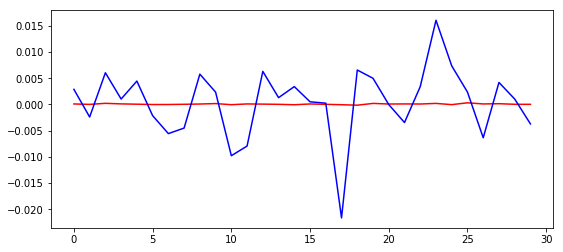

In [29]:
df_fc = df.copy()

df_fc = (df_fc - df_fc.mean()) / (df_fc.max() - df_fc.min())

response = 'Future CloseBid'

actual = 'diff closeBid'

df_fc[response] = df_fc[actual].shift(-1)

df_fc = df_fc.dropna()

X_train, X_test, y_train, y_test = train_test(df_fc, response, time_series=True)

### LINREG (price)

lr_fc = linreg(X_train, y_train)
#print(lr_fc.summary())
plt.figure(figsize=(9,4))
plt.plot(range(len(y_test[:30])),lr_fc.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

### RNN (price)

nn_fc = rnn_reg(X_train, y_train)
print(nn_fc.summary())
plt.figure(figsize=(9,4))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

plt.plot(range(len(y_test[:30])),nn_fc.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

In [ ]:
## LINREG (price)

lr_fc = linreg(X_train, y_train)
#print(lr_fc.summary())
plt.figure(figsize=(15,4))
plt.plot(range(len(y_test[:30])),lr_fc.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

### RNN (price)

nn_fc = rnn_reg(X_train, y_train, bs=512, epcs=25)
print(nn_fc.summary())
plt.figure(figsize=(15,4))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
plt.plot(range(len(y_test[:30])),nn_fc.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

# Future High (price)

In [ ]:
df_fh = df.copy()

response = 'Future diff highBid'
actual = 'diff highBid'
df_fh[response] = df_fh[actual].shift(-1)

df_fh = df_fh.dropna()

X_train, X_test, y_train, y_test = train_test(df_fh, response, time_series=True)

### LINREG (price)

lr_fh = linreg(X_train, y_train)
print(lr_fh.summary())
plt.figure(figsize=(15,4))
plt.plot(range(len(y_test[:30])),lr_fh.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

### RNN (price)

nn_fh = rnn_reg(X_train, y_train, bs=512, epcs=5)
print(nn_fh.summary())
plt.figure(figsize=(15,4))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
plt.plot(range(len(y_test[:30])),nn_fh.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

# Future Low (price)

In [ ]:
df_fl = df.copy()

response = 'Future diff lowBid'

actual = 'diff lowBid'

df_fl[response] = df_fl[actual].shift(-1)

df_fl = df_fl.dropna()

X_train, X_test, y_train, y_test = train_test(df_fl, response, time_series=True)

### LINREG (price)

lr_fl = linreg(X_train, y_train)
print(lr_fl.summary())
plt.figure(figsize=(15,4))
plt.plot(range(len(y_test[:30])),lr_fl.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

### RNN (price)

nn_fl = rnn_reg(X_train, y_train, bs=512, epcs=5)
print(nn_fl.summary())
plt.figure(figsize=(15,4))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
plt.plot(range(len(y_test[:30])),nn_fl.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

# Score

## Future Close (higher)

In [ ]:
df_fc = df.copy()
actual = 'diff closeBid'
response = 'Future close higher'
lim = 0.5
df_fc[response] = 0
df_fc.loc[df_fc[actual] >= 0, response] = 1
df_fc[response] = df_fc[response].shift(-1)
df_fc = df_fc.dropna()
X_train, X_test, y_train, y_test = train_test(df_fc, response, time_series=True)

### LOGREG
print('LOGREG')
lr_fc = logreg(X_train, y_train)
predictions = lr_fc.predict(X_test)
model_precision(y_test, predictions, lim)
bs = bucket_scores(y_test, predictions)
display(bs)

plt.figure(figsize=(17,18))
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=None, sample_weight=None, drop_intermediate=True)
plt.plot(fpr, tpr, 'r')
auc = np.trapz(tpr, fpr)
plt.axis([0,1,0,1])
plt.plot([0,1],[0,1], 'black')


### RNN 
print('RNN CLASS')
nn_fc = rnn_class(X_train, y_train, bs=512, epcs=20)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
predictions = nn_fc.predict(X_test)
model_precision(y_test, predictions, lim)
bs = bucket_scores(y_test, predictions)
display(bs)

fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=None, sample_weight=None, drop_intermediate=True)
plt.plot(fpr, tpr, 'b')

plt.show()

## Future High (higher)

In [ ]:
df_fh = df.copy()
actual = 'diff highBid'
response = 'Future high higher'
lim = 0.5
df_fh[response] = 0
df_fh.loc[df_fh[actual] >= 0, response] = 1
df_fh[response] = df_fh[response].shift(-1)
df_fh = df_fh.dropna()
X_train, X_test, y_train, y_test = train_test(df_fh, response, time_series=True)

### LOGREG
print('LOGREG')
lr_fh = logreg(X_train, y_train)
predictions = lr_fh.predict(X_test)
model_precision(y_test, predictions, lim)
bs = bucket_scores(y_test, predictions)
display(bs)

plt.figure(figsize=(17,18))
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=None, sample_weight=None, drop_intermediate=True)
plt.plot(fpr, tpr, 'r')
auc = np.trapz(tpr, fpr)
plt.axis([0,1,0,1])
plt.plot([0,1],[0,1], 'black')

### RNN 
print('RNN CLASS')
nn_fh = rnn_class(X_train, y_train, bs=512, epcs=20)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
predictions = nn_fh.predict(X_test)
model_precision(y_test, predictions, lim)
bs = bucket_scores(y_test, predictions)
display(bs)

fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=None, sample_weight=None, drop_intermediate=True)
plt.plot(fpr, tpr, 'b')

plt.show()

## Future Low (higher)

In [ ]:
df_fl = df.copy()
actual = 'diff lowBid'
response = 'Future low higher'
lim = 0.5
df_fl[response] = 0
df_fl.loc[df_fl[actual] >= 0, response] = 1
df_fl[response] = df_fl[response].shift(-1)
df_fl = df_fl.dropna()
X_train, X_test, y_train, y_test = train_test(df_fl, response, time_series=True)

### LOGREG
print('LOGREG')
lr_fl = logreg(X_train, y_train)
predictions = lr_fl.predict(X_test)
model_precision(y_test, predictions, lim)
bs = bucket_scores(y_test, predictions)
display(bs)

plt.figure(figsize=(17,18))
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=None, sample_weight=None, drop_intermediate=True)
plt.plot(fpr, tpr, 'r')
auc = np.trapz(tpr, fpr)
plt.axis([0,1,0,1])
plt.plot([0,1],[0,1], 'black')

### RNN 
print('RNN CLASS')
nn_fl = rnn_class(X_train, y_train, bs=512, epcs=20)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
predictions = nn_fl.predict(X_test)
model_precision(y_test, predictions, lim)
bs = bucket_scores(y_test, predictions)
display(bs)

fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=None, sample_weight=None, drop_intermediate=True)
plt.plot(fpr, tpr, 'b')

plt.show()

# Trading

In [ ]:
response = oanda.get_history(instrument="USD_JPY", granularity='M5', since='2018-08-23T01:00:00.00000Z')

In [ ]:
pd.DataFrame(response['candles'])